In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision.models as models
import torch.cuda.amp as amp
import os
import shutil
import zipfile
from PIL import Image
import matplotlib.pyplot as plt
import shutil
import numpy as np
import gc
import IPython
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

checkpoint_dir = "model_checkpoints"
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)
os.makedirs(checkpoint_dir, exist_ok=True)
torch.cuda.empty_cache()

In [2]:
#seed = 42
#torch.manual_seed(seed)
#np.random.seed(seed)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [4]:
def check_and_clear_cuda_memory():
    free_mem, total_mem = torch.cuda.mem_get_info()
    print(f"Before Clearing - Free memory: {free_mem / 1024**2:.2f} MB / {total_mem / 1024**2:.2f} MB")

    gc.collect()
    torch.cuda.empty_cache()
    IPython.display.clear_output(wait=True)  # Clear Jupyter output

    free_mem, total_mem = torch.cuda.mem_get_info()
    print(f"After Clearing - Free memory: {free_mem / 1024**2:.2f} MB / {total_mem / 1024**2:.2f} MB")

check_and_clear_cuda_memory()

After Clearing - Free memory: 11034.06 MB / 11172.19 MB


In [5]:
data_dir = "tiny-imagenet-200"

In [6]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3))
])


val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
from PIL import Image
img_path = "tiny-imagenet-200/train/n01443537/images/n01443537_0.JPEG"
img = Image.open(img_path)
print(type(img))

<class 'PIL.JpegImagePlugin.JpegImageFile'>


In [8]:
#subset_size = 8000  # Adjust size , max is 100000
#train_dataset_full = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
#indices = np.random.choice(len(train_dataset_full), subset_size, replace=False)  # Fixed subset indices
#train_dataset = torch.utils.data.Subset(train_dataset_full, indices)
#train_dataset = torch.utils.data.Subset(train_dataset_full, range(subset_size))
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_transforms)

In [9]:
def create_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8,  pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8,  pin_memory=True,  drop_last=True)
    return train_loader, val_loader

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(256)

        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn8 = nn.BatchNorm2d(512)

        self.dropout = nn.Dropout(0.5)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 200)

        self.alpha_conv = nn.Parameter(torch.full((1,), 0.01))  # Learnable α for conv layers
        self.alpha_fc = nn.Parameter(torch.full((1,), 0.01))

    def forward(self, x):
        x = F.prelu(self.bn1(self.conv1(x)), self.alpha_conv)
        x = F.prelu(self.bn2(self.conv2(x)), self.alpha_conv)

        x = F.prelu(self.bn3(self.conv3(x)), self.alpha_conv)
        x = F.prelu(self.bn4(self.conv4(x)), self.alpha_conv)

        x = F.prelu(self.bn5(self.conv5(x)), self.alpha_conv)
        x = F.prelu(self.bn6(self.conv6(x)), self.alpha_conv)

        x = F.prelu(self.bn7(self.conv7(x)), self.alpha_conv)
        x = F.prelu(self.bn8(self.conv8(x)), self.alpha_conv)

        x = self.adaptive_pool(x)
        x = torch.flatten(x, start_dim=1)
        
        x = self.dropout(F.prelu(self.fc1(x), self.alpha_fc))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

# Initialize model with Kaiming initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

CNN().to(device)

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn6)

In [11]:
def evaluate_model(model, data_loader, dataset_name="Validation"):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs, 1) #Accuracy computation
            total += labels.size(0) 
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'{dataset_name} Accuracy: {accuracy:.4f}')
    return accuracy

train_acc_list, val_acc_list, train_loss_list, val_loss_list, epoch_listings = [], [], [], [], []

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler):
    num_epochs = 500
    patience = 5  
    min_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss_train = 0.0
        correct_train, total_train = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss_train += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        scheduler.step()

        epoch_loss_train = running_loss_train / len(train_loader.dataset)
        train_accuracy = correct_train / total_train

        # Validation phase
        model.eval()
        running_loss_val = 0.0
        correct_val, total_val = 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        epoch_loss_val = running_loss_val / len(val_loader.dataset)
        val_accuracy = correct_val / total_val

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss_train:.4f}, Val Loss: {epoch_loss_val:.4f}')
        print(f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}\n')

        # Early Stopping Check
        if epoch_loss_val < min_val_loss:
            min_val_loss = epoch_loss_val
            patience_counter = 0  # Reset patience
            # Save best model
            #torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_model.pth'))
            print("Best model")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            return min_val_loss
        
    print("Training complete.")
    return min_val_loss

Val Loss with (Smoothing: 0.05, LR: 0.05, Weight Decay: 1e-04, Batch Size: 32, Step Size: 1, Gamma: 0.5)

In [33]:
from itertools import product

param_grid = {
    'label_smoothing': [0.05],
    'lr': [0.0001],
    'weight_decay': [1e-4],
    'batch_size': [32],
    'step_size': [4],
    'gamma': [0.5]
}

# Generate all possible parameter combinations
param_combinations = list(product(*param_grid.values()))
dct = {}
for params in param_combinations:
    label_smoothing, lr, weight_decay, batch_size, step_size, gamma = params
    print()
    print(f"Training with Smoothing: {label_smoothing}, LR: {lr}, Weight Decay: {weight_decay}, Batch Size: {batch_size}, Step Size: {step_size}, Gamma: {gamma}")

    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) #0.00005
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_loader, val_loader = create_dataloaders(batch_size)  # Assume a function for this
    min_val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)  # Train using your loop
    print(f"Val Loss with (Smoothing: {label_smoothing}, LR: {lr}, Weight Decay: {weight_decay}, Batch Size: {batch_size}, Step Size: {step_size}, Gamma: {gamma}):")
    print(f"{min_val_loss}")



Training with Smoothing: 0.05, LR: 0.0001, Weight Decay: 0.0001, Batch Size: 32, Step Size: 4, Gamma: 0.5


KeyboardInterrupt: 

In [16]:
train_acc_list, val_acc_list, train_loss_list, val_loss_list, epoch_listings = [], [], [], [], []

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)
train_loader, val_loader = create_dataloaders(256)  # Assume a function for this

num_epochs = 20
min_val_loss = float('inf')

for epoch in range(num_epochs):
    epoch_listings.append(epoch)
    model.train()
    running_loss_train = 0.0
    correct_train, total_train = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss_train += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    scheduler.step()

    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    train_accuracy = correct_train / total_train

    train_acc_list.append(train_accuracy)
    train_loss_list.append(epoch_loss_train)

    # Validation phase
    model.eval()
    running_loss_val = 0.0
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss_val += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    epoch_loss_val = running_loss_val / len(val_loader.dataset)
    val_accuracy = correct_val / total_val

    val_acc_list.append(val_accuracy)
    val_loss_list.append(epoch_loss_val)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss_train:.4f}, Val Loss: {epoch_loss_val:.4f}')
    print(f'Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}\n')

    # Early Stopping Check
    if epoch_loss_val < min_val_loss:
        min_val_loss = epoch_loss_val
        best_model = model
        print("Best model")
        
print("Training complete.")

Epoch 1/20, Train Loss: 5.1518, Val Loss: 5.6691
Train Accuracy: 0.0185, Val Accuracy: 0.0005

Best model
Epoch 2/20, Train Loss: 4.9579, Val Loss: 6.0212
Train Accuracy: 0.0316, Val Accuracy: 0.0092

Epoch 3/20, Train Loss: 4.8001, Val Loss: 6.4098
Train Accuracy: 0.0430, Val Accuracy: 0.0025

Epoch 4/20, Train Loss: 4.6855, Val Loss: 6.8901
Train Accuracy: 0.0523, Val Accuracy: 0.0036

Epoch 5/20, Train Loss: 4.5902, Val Loss: 6.9913
Train Accuracy: 0.0627, Val Accuracy: 0.0050

Epoch 6/20, Train Loss: 4.5514, Val Loss: 7.7940
Train Accuracy: 0.0665, Val Accuracy: 0.0049

Epoch 7/20, Train Loss: 4.5039, Val Loss: 7.9217
Train Accuracy: 0.0698, Val Accuracy: 0.0029

Epoch 8/20, Train Loss: 4.4640, Val Loss: 7.4658
Train Accuracy: 0.0755, Val Accuracy: 0.0053

Epoch 9/20, Train Loss: 4.4193, Val Loss: 7.7955
Train Accuracy: 0.0800, Val Accuracy: 0.0064

Epoch 10/20, Train Loss: 4.3949, Val Loss: 7.9239
Train Accuracy: 0.0831, Val Accuracy: 0.0071

Epoch 11/20, Train Loss: 4.3723, Val L

In [17]:
# Training Evaluation
evaluate_model(best_model, train_loader, "Training")

# Validation Evaluation
evaluate_model(best_model, val_loader, "Validation")

# Testing Evaluation
#evaluate_model(model, test_loader, "Testing")

Training Accuracy: 0.1190
Validation Accuracy: 0.0086


0.008613782051282052

In [18]:
final_model_path = os.path.join(checkpoint_dir, 'tiny_imagenet_cnn.pth')
torch.save(best_model.state_dict(), final_model_path)

In [33]:
val_loss_list = [train_loss_list[i] for i in range(1, 40, 2)]
train_loss_list = [train_loss_list[i] for i in range(0, 40, 2)]
val_loss_list = [train_loss_list[i] for i in range(1, 40, 2)]
train_loss_list = [train_loss_list[i] for i in range(0, 40, 2)]

In [34]:
train_acc_lis

NameError: name 'train_acc_lis' is not defined

ValueError: x and y must have same first dimension, but have shapes (20,) and (40,)

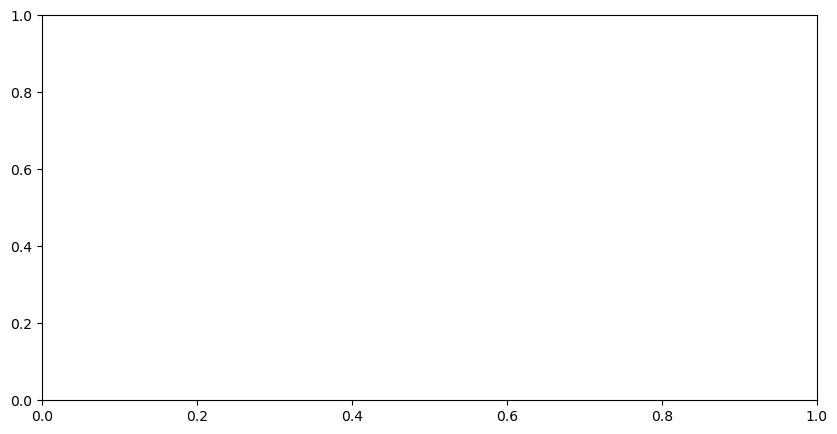

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(epoch_listings, train_loss_list, label='Training Loss')
plt.plot(epoch_listings, val_loss_list, label='Validation Loss', linestyle='dashed')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

In [ ]:
plt.plot(epoch_listings, train_acc_list, label="Train Accuracy")
plt.plot(epoch_listings, val_acc_list, label="Validation Accuracy")
#plt.plot(epoch_listings, test_acc_list, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Progress")
plt.show()

In [ ]:
best_model.load_state_dict(torch.load(final_model_path, map_location=device))  # Load model to the correct device
best_model.to(device)
best_model.eval()

def predict_images(image_paths):
    predictions = {}
    for image_path in image_paths:
        image = Image.open(image_path)
        image = val_transforms(image).unsqueeze(0).to(device)
        with torch.no_grad():
            output = best_model(image)
            _, predicted_class = torch.max(output, 1)
        predictions[image_path] = train_dataset.dataset.classes[predicted_class.item()]
    return predictions


In [ ]:
image_paths = [
    "tiny-imagenet-200/val/images/val_0.JPEG",
    "tiny-imagenet-200/val/images/val_1.JPEG",
    "tiny-imagenet-200/val/images/val_2.JPEG"
]
predictions = predict_images(image_paths)

In [ ]:
for image_path, predicted_label in predictions.items():
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(predicted_label)
    plt.show()

## 